In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch 
from torch.utils.data import Dataset, Subset
from torch.utils.data import random_split
from PIL import Image
import os
import numpy as np
save_dir = '/Users/jgold/Documents/GitHub/COMP432_project/dataset'

In [2]:
transformation = transforms.Compose( [transforms.Resize((32,32)), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                          std=[0.5, 0.5, 0.5])])

#change average sizes
#grabbing dataset
dataset = torchvision.datasets.ImageFolder('/Users/jgold/Documents/GitHub/COMP432_project/dataset', 
                                                transform=transformation)

#randomly splitting for training and testing
training_set, testing_set = random_split(dataset, [2494, 832])


                                                
train_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=100, shuffle=True, num_workers=2)


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td


#building neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 64, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
    )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [4]:
num_epochs = 2
num_classes = 10
learning_rate = 0.001


In [5]:
#initializing CNN
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
#training the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
        (correct / total) * 100))

Epoch [1/2], Step [25/25], Loss: 1.7046, Accuracy: 30.85%
Epoch [2/2], Step [25/25], Loss: 1.5433, Accuracy: 39.36%


In [7]:
#Saving Model
# path = r"/Users/jgold/Documents/GitHub/Artifical-Intelligence-Project/Models/Model2.pt"

# torch.save(model.state_dict(), path)

In [8]:
#testing the model after it has beeen trained
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 600 test images: {} %'
          .format((correct / total) * 100))

Test Accuracy of the model on the 600 test images: 44.0 %
Test Accuracy of the model on the 600 test images: 44.5 %
Test Accuracy of the model on the 600 test images: 41.333333333333336 %
Test Accuracy of the model on the 600 test images: 41.25 %
Test Accuracy of the model on the 600 test images: 41.0 %
Test Accuracy of the model on the 600 test images: 41.66666666666667 %
Test Accuracy of the model on the 600 test images: 41.85714285714286 %
Test Accuracy of the model on the 600 test images: 41.5 %
Test Accuracy of the model on the 600 test images: 41.34615384615385 %


Time to evaluate our data.
First will be the training data.


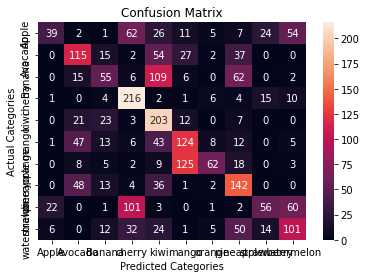

              precision    recall  f1-score   support

           0       0.17      0.57      0.26        69
           1       0.46      0.45      0.45       256
           2       0.22      0.39      0.28       142
           3       0.83      0.50      0.62       434
           4       0.75      0.40      0.52       509
           5       0.48      0.40      0.44       308
           6       0.27      0.68      0.38        91
           7       0.58      0.42      0.48       341
           8       0.23      0.51      0.32       109
           9       0.41      0.43      0.42       235

    accuracy                           0.45      2494
   macro avg       0.44      0.47      0.42      2494
weighted avg       0.56      0.45      0.47      2494



In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

print("Time to evaluate our data.")
print("First will be the training data.")

#building Confusion Matrix as well as getting accuracy, predictions and F1 score for train model
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
  
  
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])
confusionMatrix.yaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for training model
print(classification_report(prediction_list, accurate_list))

Now to evaluate the testing data.


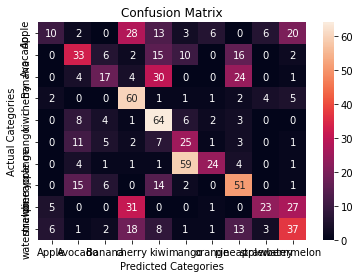

              precision    recall  f1-score   support

           0       0.11      0.43      0.18        23
           1       0.39      0.42      0.41        78
           2       0.21      0.41      0.28        41
           3       0.79      0.41      0.54       147
           4       0.73      0.42      0.53       153
           5       0.45      0.23      0.31       107
           6       0.25      0.67      0.37        36
           7       0.57      0.44      0.50       116
           8       0.26      0.64      0.37        36
           9       0.41      0.39      0.40        95

    accuracy                           0.41       832
   macro avg       0.42      0.45      0.39       832
weighted avg       0.53      0.41      0.44       832



In [10]:
#building Confusion Matrix as well as getting accuracy, predictions and F1 score for test model

print("Now to evaluate the testing data.")
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
  
  
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])
confusionMatrix.yaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for testing model
print(classification_report(prediction_list, accurate_list))

In [11]:
bias_dataset_adult = torchvision.datasets.ImageFolder('/Users/jgold/Documents/GitHub/Artifical-Intelligence-Project/BiasDataset/Adult', 
                                                transform=transformation)

bias_loader_adult = torch.utils.data.DataLoader(bias_dataset_adult, batch_size=100, shuffle=True, num_workers=2)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/jgold/Documents/GitHub/Artifical-Intelligence-Project/BiasDataset/Adult'

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in bias_loader_adult :
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 50 Adult images: {} %'
          .format((correct / total) * 100))

In [ ]:
print("Now to evaluate the Adult data.")
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in bias_loader_adult:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
  
  
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])
confusionMatrix.yaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for testing model
print(classification_report(prediction_list, accurate_list))

In [ ]:
bias_dataset_child = torchvision.datasets.ImageFolder('/Users/jgold/Documents/GitHub/Artifical-Intelligence-Project/BiasDataset/Child', 
                                                transform=transformation)

bias_loader_child = torch.utils.data.DataLoader(bias_dataset_child, batch_size=100, shuffle=True, num_workers=2)

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in bias_loader_child :
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 50 Child images: {} %'
          .format((correct / total) * 100))

In [ ]:
print("Now to evaluate the child data.")
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in bias_loader_child:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
  
  
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])
confusionMatrix.yaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for testing model
print(classification_report(prediction_list, accurate_list))

In [ ]:
bias_dataset_female = torchvision.datasets.ImageFolder('/Users/jgold/Documents/GitHub/Artifical-Intelligence-Project/BiasDataset/Female', 
                                                transform=transformation)

bias_loader_female = torch.utils.data.DataLoader(bias_dataset_female, batch_size=100, shuffle=True, num_workers=2)

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in bias_loader_female :
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 50 female images: {} %'
          .format((correct / total) * 100))

In [ ]:
print("Now to evaluate the Female data.")
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in bias_loader_female:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
  
  
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])
confusionMatrix.yaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for testing model
print(classification_report(prediction_list, accurate_list))

In [ ]:
bias_dataset_male = torchvision.datasets.ImageFolder('/Users/jgold/Documents/GitHub/Artifical-Intelligence-Project/BiasDataset/Male', 
                                                transform=transformation)

bias_loader_male = torch.utils.data.DataLoader(bias_dataset_male, batch_size=100, shuffle=True, num_workers=2)

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in bias_loader_male :
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 50 male images: {} %'
          .format((correct / total) * 100))

In [ ]:
print("Now to evaluate the Male data.")
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in bias_loader_male:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
  
  
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])
confusionMatrix.yaxis.set_ticklabels(['Cloth Mask','N95','No Mask','Surgical Mask'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for testing model
print(classification_report(prediction_list, accurate_list))